In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import torch.nn as nn
import math

# Dataset

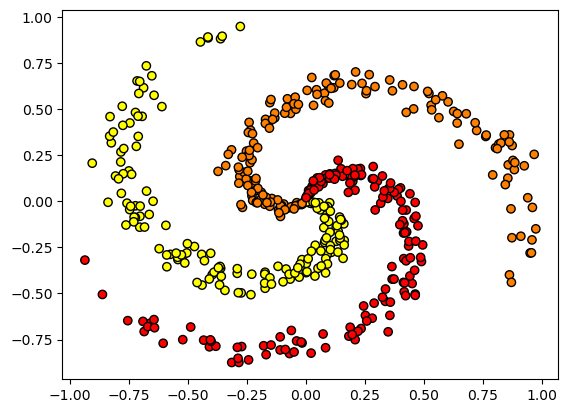

In [2]:
def make_3spiral(n_per_class=200, noise=0.2):
    X, y = [], []
    for k in range(3):
        r = np.linspace(0.0, 1.0, n_per_class)
        t = np.linspace(k*4, (k+1)*4, n_per_class) + np.random.randn(n_per_class)*noise
        x1 = r * np.sin(t)
        x2 = r * np.cos(t)
        X.append(np.stack([x1, x2], axis=1))
        y.append(np.full(n_per_class, k))
    return np.vstack(X), np.concatenate(y)

X, y = make_3spiral()
N = len(X)
rng = np.random.default_rng(seed=0)
perm = rng.permutation(N)

X = X[perm]
y = y[perm]

n_train = int(0.8 * N)

X_train = X[:n_train]
y_train = y[:n_train]
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test  = X[n_train:]
y_test  = y[n_train:]
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');

# Network and Liklihoods

In [3]:
class SpiralNetwork(nn.Module):
    def __init__(self, hidden=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
             nn.ReLU(),
            nn.Linear(hidden, 3)      # <-- 3 classes: logits for classes {0,1,2}
        )

    def forward(self, x):
        return self.net(x)      
    
network = SpiralNetwork()

In [4]:
def log_likelihood(network, X, y):
    logits = network(X)  # (B, 3)
    return dist.Categorical(logits=logits).log_prob(y).sum()

def log_prior(network):
    log_prob = 0.0
    for p in network.parameters():
        log_prob = log_prob  + dist.Normal(0, 1).log_prob(p).sum()
    return log_prob

def log_joint_minibatch(network, X_batch, y_batch, N_training):
    lp = log_prior(network)
    ll_batch = log_likelihood(network, X_batch, y_batch)
    batch_size = X_batch.shape[0]
    return lp + ll_batch * N_training / batch_size

def log_joint_full(network, X_full, y_full):
    lp = log_prior(network)
    ll = log_likelihood(network, X_full, y_full)  # sum over all data
    return lp + ll

In [5]:
with torch.no_grad():
    full_data_lp = log_prior(network) + log_likelihood(network, X_train, y_train)
print("Full data log probability: %0.4f" % full_data_lp.item())

Full data log probability: -10404.2070


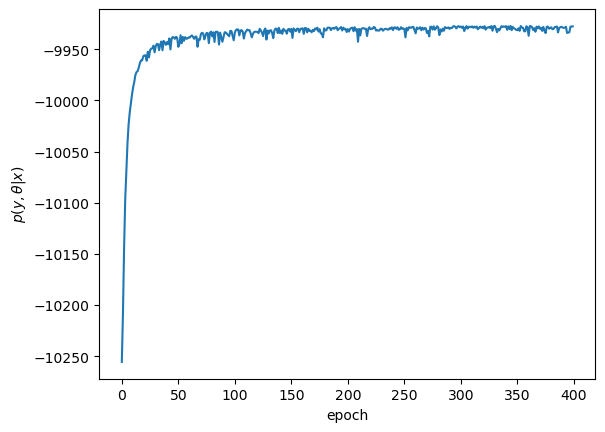

In [6]:
dataset = torch.utils.data.TensorDataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)
opt = torch.optim.Adam(network.parameters())

N_epochs = 400
train_lp = []

for epoch in range(N_epochs):
    for X, y in dataloader:
        opt.zero_grad()
        loss = -log_joint_minibatch(network, X, y, len(dataset))
        loss.backward()
        opt.step()
    with torch.no_grad():
        train_lp.append((log_likelihood(network, X_train, y_train) + log_prior(network)).item())
plt.plot(train_lp)
plt.xlabel("epoch")
plt.ylabel("$p(y, \\theta | x)$");

## Non-Bayesian cobfidence plot

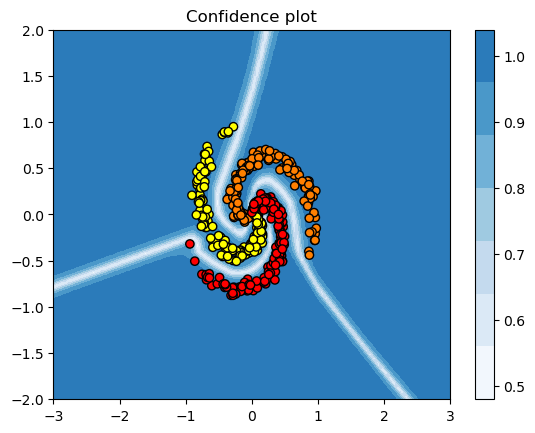

In [7]:
XX, YY = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-2, 2, 100))
with torch.no_grad():
    grid = torch.FloatTensor(np.stack((XX.ravel(), YY.ravel())).T)
    logits = network(grid)                
    probs = torch.softmax(logits, dim=1)   
    conf, _ = probs.max(dim=1)              
    ZZ = conf.reshape(XX.shape)            
CS = plt.contourf(XX, YY, ZZ, cmap='Blues', vmin=0.5, vmax=1.2)
plt.colorbar(ticks=np.linspace(0.5, 1, 6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k')
plt.title("Confidence plot");

In [8]:
def expected_calibration_error(y, y_hat, N_bins=10):
    if y_hat.ndim == 2:
        probs = torch.softmax(y_hat, dim=1)
        conf, pred = probs.max(dim=1)          # (N,), (N,)
    else:
        # binary fallback: y_hat is probs in [0,1]
        conf = torch.where(y_hat > 0.5, y_hat, 1 - y_hat)
        pred = (y_hat > 0.5).long()

    correct = (pred == y).float()              # (N,)

    bins = torch.linspace(0, 1, N_bins + 1, device=conf.device)
    bin_ids = torch.bucketize(conf, bins[1:], right=True)

    ece = torch.tensor(0.0, device=conf.device)
    N = y.numel()

    for b in range(N_bins):
        mask = (bin_ids == b)
        if mask.any():
            bin_acc = correct[mask].mean()
            bin_conf = conf[mask].mean()
            ece += (mask.sum().float() / N) * torch.abs(bin_acc - bin_conf)

    return ece.item()

In [9]:
validation_set = torch.utils.data.TensorDataset(X_test, y_test)
with torch.no_grad():
    y_hat = network(validation_set.tensors[0])

print("ECE = %0.4f" % expected_calibration_error(validation_set.tensors[1], y_hat));

ECE = 0.0287


# Sampling Algorithm SGLD

In [10]:
dataset = torch.utils.data.TensorDataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

In [11]:
def SGLD_step(network, X, y, N_training, epsilon):
    network.zero_grad()
    lp = log_joint_minibatch(network, X, y, N_training)
    lp.backward()

    with torch.no_grad():
        for p in network.parameters():
            p += 0.5*epsilon**2 * p.grad + epsilon*torch.randn(p.shape) 

In [12]:
def learning_rate_schedule(N_steps, N_samples, epsilon):
    return epsilon * (np.cos(np.pi * (np.arange(N_samples*N_steps) % N_steps)/N_steps) + 1)


def learning_rate_schedule_old(N_steps, N_samples, epsilon, alpha=0.55):
    T = N_steps * N_samples
    t = np.arange(T)
    return epsilon / (1.0 + t)**alpha

In [13]:
def draw_sgld_samples(network, N_samples, N_steps_per_sample, base_epsilon=0.01):
    lr_schedule = learning_rate_schedule(N_steps_per_sample, N_samples, base_epsilon)
    samples = []
    step = 0
    while True:
        for X, y in dataloader:
            SGLD_step(network, X, y, len(dataset), epsilon=lr_schedule[step])
            step += 1
            if step % N_steps_per_sample == 0:
                samples.append(nn.utils.parameters_to_vector(network.parameters()).detach())
            if step == len(lr_schedule):
                return torch.stack(samples)

In [14]:
samples = draw_sgld_samples(network, N_samples=200, N_steps_per_sample=200)
print("Tensor holding samples of theta has shape:", samples.shape)

Tensor holding samples of theta has shape: torch.Size([200, 10703])


## Bayesian confidence plot

In [15]:
def predict_from_samples(X, network, samples):
    out = []
    for v in samples:
        nn.utils.vector_to_parameters(v, network.parameters())
        out.append(network(X).squeeze(-1))
    return torch.stack(out)

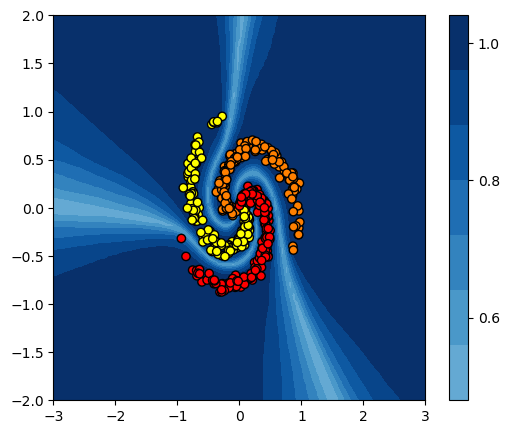

In [16]:
XX, YY = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-2, 2, 100))

with torch.no_grad():
    grid = torch.tensor(np.stack((XX.ravel(), YY.ravel())).T, dtype=torch.float32)  # (N,2)
    logits_s = predict_from_samples(grid, network, samples)  
    probs_s = torch.softmax(logits_s, dim=-1)                 
    probs = probs_s.mean(dim=0)                               
    conf, _ = probs.max(dim=1)                                
    ZZ = conf.reshape(XX.shape).cpu().numpy()                 

plt.figure(figsize=(6,5))
plt.contourf(XX, YY, ZZ, cmap='Blues', vmin=0.0, vmax=1.0)
plt.colorbar(ticks=np.linspace(0, 1, 6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k')
#plt.title("Confidence Plot")

plt.savefig("3spiral_Uncertplot.png", dpi=300, bbox_inches="tight")
plt.show()

## Uncertainity Quantification

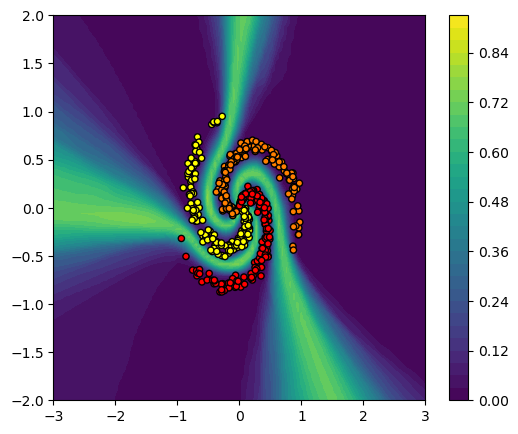

In [17]:
def entropy_from_probs(p, eps=1e-12):
    p = torch.clamp(p, eps, 1.0)
    return -(p * p.log()).sum(dim=-1)

grid = torch.tensor(np.stack([XX.ravel(), YY.ravel()], axis=1), dtype=torch.float32)

with torch.no_grad():
    out = predict_from_samples(grid, network, samples)  
    probs_s = torch.softmax(out, dim=-1)               
    probs = probs_s.mean(dim=0)                       
    H = entropy_from_probs(probs)                     

ZZ = H.reshape(XX.shape).cpu().numpy()

plt.figure(figsize=(6,5))
plt.contourf(XX, YY, ZZ, levels=30)
plt.colorbar()
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="autumn", edgecolor="k", s=20)
#plt.title("Uncertanity")

plt.savefig("3spiral_predictiveentropy.png", dpi=300, bbox_inches="tight")
plt.show()